In [6]:
import numpy
import pandas
import matplotlib.pyplot as plt
import sys

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from datetime import datetime as dt
import time
import math
import tensorflow as tf
from keras import backend as K

config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)


#スタート時間を保持
starttime = time.time()

# 学習の設定
#l_of_s         = 20
#n_next         = 5
l_of_s         = 20
n_next         = 5

in_out_neurons = 1
hidden_neurons = 300

# 学習用データを抽出する関数
def _load_data(data, n_prev=10, n_next=1, flag=True):
    docX, docY = [], []
    for i in range(n_prev, len(data)-n_next):
        #起点の箇所からn_prevだけ戻った日数分をデータとする
        docX.append(data.iloc[i-n_prev:i].as_matrix())
        #起点の翌日からn_next日数分進んだデータのmax or minをyデータとする
        if flag == True:
            docY.append(max(data.iloc[i+1:i+1+n_next].as_matrix()))
        else:
            docY.append(min(data.iloc[i+1:i+1+n_next].as_matrix()))

    alsX = numpy.array(docX)
    alsY = numpy.array(docY)
    return alsX, alsY


In [7]:
import urllib.request

#ダウンロードする通貨ペア
#https://stooq.com/q/d/?s=usdjpy
#ついでにsekjpy、nokjpy、mxnjpy、sgdjpyとかもありますが、
#2000/01/01からデータがない（あるけど、しばらくopen/high/low/closeがすべて一緒)ので
#ここには７通貨ペアしか記載しておりません。日付とか調整して通貨ペアを増やしてみても
#いいと思います
currency_pair = 'usdjpy'
#currency_pair = 'eurjpy'
#currency_pair = 'gbpjpy'
#currency_pair = 'audjpy'
#currency_pair = 'cadjpy'
#currency_pair = 'chfjpy'
#currency_pair = 'nzdjpy'
#currency_pair = 'sekjpy'
#currency_pair = 'nokjpy'

#スタート日付
start_day     = "20010101"
#終了日を今日に指定
url           = "https://stooq.com/q/d/l/?s=" + currency_pair + \
                "&d1=" + start_day + "&d2=" + dt.today().strftime("%Y%m%d") + "&i=d"
file_name     = currency_pair + '_d.csv'
#取得して、ファイルに保存(よくよく考えると保存しなくてもいいな)
urllib.request.urlretrieve(url, file_name)


In [8]:
# FXデータの読み込み
data = None
data = pandas.read_csv(file_name)
data.columns = ['date', 'open', 'high', 'low', 'close']
data['date'] = pandas.to_datetime(data['date'], format='%Y-%m-%d')

#train開始終了、test開始終了日を設定
#データは2001/01/01からとっていますが、さかのぼって調査する関係上
#20001/01/01からにしています。また買い目対象の調査としてtest_end_dayよりも
#後の日も参照するためtest_end_dayの取得するデータにはしないでください。
#trainの終了日とtestの開始日が連続していますが、連続させなくても動作するか
#検証していません。注意してください
train_start_day   = dt.strptime('2002-01-01', '%Y-%m-%d')
train_end_day     = dt.strptime('2013-12-31', '%Y-%m-%d')
test_start_day    = dt.strptime('2014-01-01', '%Y-%m-%d')
test_end_day      = dt.strptime('2016-12-31', '%Y-%m-%d')
train_start_count = -1
train_end_count   = -1
test_start_count  = -1
test_end_count    = -1

#train/testの開始終了日の配列の場所を調査
for i in range(len(data['date'])):
    if train_start_count == -1 and data['date'][i] >= train_start_day:
        train_start_count = i
    if train_end_count == -1 and data['date'][i] >= train_end_day:
        train_end_count = i
    if test_start_count == -1 and data['date'][i] >= test_start_day:
        test_start_count = i
    if test_end_count == -1 and data['date'][i] >= test_end_day:
        test_end_count = i
        break

#前にl_of_s日分、後ろにn_next分日数が必要なので
#チェック。足りない場合は中止。これを考慮に入れて
#train/testの開始終了日を設定してください
if train_start_count - l_of_s < 0 or \
    test_end_count + n_next > len(data['date']):
    
    print("data range over")
    sys.exit()
    
print('Train Start: ' + str(train_start_count))
print('Train End  : ' + str(train_end_count))
print('Test  Start: ' + str(test_start_count))
print('Test  End  : ' + str(test_end_count))

up_down           = []
up_count          = 0
down_count        = 0
even_count        = 0
#up/downの割合
check_treshhold   = 0.666
loop_flag         = True

#
check_add_percent = 0.0020
check_percent     = 0.02
if min(data.loc[:, 'low']) > 150:
    check_add_percent = 0.20
    check_percent     = 2.0
elif min(data.loc[:, 'low']) > 30:
    check_add_percent = 0.020
    check_percent     = 0.2
    check_percent     = 0.58
    
#close_open_diff = numpy.array([])
#for i in range(train_start_count, test_end_count):
#    close_open_diff = numpy.append(close_open_diff, numpy.array(data.loc[i-1, 'close'] - data.loc[i, 'open']))
#print('Close-Open Diff:' + str(close_open_diff.mean()) + ' ' + str(close_open_diff.std()))
#up_c_o_diff   = close_open_diff.mean() + close_open_diff.std() * 2
#down_c_o_diff = close_open_diff.mean() - close_open_diff.std() * 2
#c_o_d_remove_count = 0
#for i in range(train_start_count, test_end_count):
#    if data.loc[i-1, 'close'] - data.loc[i, 'open'] >= up_c_o_diff or \
#        data.loc[i-1, 'close'] - data.loc[i, 'open'] <= down_c_o_diff:
#        c_o_d_remove_count += 1
#print("c_o_d_remove_count:" + str(c_o_d_remove_count))

while loop_flag:
    up_count = 0
    down_count = 0
    even_count = 0
    check_percent += check_add_percent
    for i in range(train_start_count, test_end_count):
        #起点の日の翌日のopenの値
        open_value = data.loc[i+1, 'open']
        #起点の日から翌日からn_next日数分のhighの最大値
        max_value = max(data.loc[i+1:i+1+n_next, 'high'])
        #起点の日から翌日からn_next日数分のlowの最小値
        min_value = min(data.loc[i+1:i+1+n_next, 'low'])
        #ここは起点の日の翌日のopenの値と起点の日の翌日から
        #n_next日数分のhighの最高値かlowの最小値が規定の値上に
        #差が広がったカウントを調べる。これで上がった・下がったを
        #回数を調べる
        
        if abs(max_value - open_value) >= check_percent and \
            abs(open_value - min_value) < check_percent:
            up_count += 1
        elif abs(open_value - min_value) >= check_percent and \
            abs(max_value - open_value) < check_percent:
            down_count += 1  
        else:
            even_count += 1
    
    #(上がった日+下がった日)/全体の日数でcheck_treshholdを超えたか調べる
    #超えていればその値をベースにする
    print('(U+D)/(U+D+E): ' + str(math.floor((up_count + down_count) / \
                                             (up_count + down_count +even_count) * 100)) + '%')    
    if (up_count + down_count) / (up_count + down_count +even_count) > check_treshhold:
        break

#上がった・下がったの判定するための数字（もっと言うと円がどれだけ動いたか）
print('p            : ' + str(check_percent))
print("UP   COUNT   : " + str(up_count))
print("DOWN COUNT   : " + str(down_count))
print("EVNE COUNT   : " + str(even_count))
print('(U+D)/(U+D+E): ' + str(math.floor((up_count + down_count) / \
                                         (up_count + down_count +even_count) * 100)) + '%')    

#sys.exit()
#上がった・下がったの判定用
#ここではtestの範囲のみ取得
for i in range(test_start_count, test_end_count):
    open_value = data.loc[i+1, 'open']
    close_value = data.loc[i, 'open']
    #起点の日から翌日からn_next日数分のhighの最大値
    max_value = max(data.loc[i+1:i+1+n_next, 'high'])
    #起点の日から翌日からn_next日数分のlowの最小値
    min_value = min(data.loc[i+1:i+1+n_next, 'low'])
    #ここは起点の日の翌日のopenの値と起点の日の翌日から
    #n_next日数分のhighの最高値かlowの最小値が規定の値上に
    #差が広がったカウントを調べる。これで上がった・下がったを
    #回数を調べる
    if abs(max_value - open_value) >= check_percent and \
        abs(open_value - min_value) < check_percent:
        up_down.append(1)
    elif abs(open_value - min_value) >= check_percent and \
        abs(max_value - open_value) < check_percent:
        up_down.append(-1)
    else:
        up_down.append(0)

#正規化
max_value = max(data['high'])
min_value = min(data['low'])
average_value = (max_value+min_value)/2
diff_value = max_value - average_value
print ('max: ' + str(max_value))
print ('min: ' + str(min_value))
print ('ave: ' + str(average_value))
print ('dif: ' + str(diff_value))

for i in range(len(data['high'].index)):
    data.loc[i, 'high'] = (data.loc[i, 'high'] - average_value) / diff_value
    data.loc[i, 'low']  = (data.loc[i, 'low'] - average_value) / diff_value
    data.loc[i, 'open'] = (data.loc[i, 'open'] - average_value) / diff_value
    data.loc[i, 'close'] = (data.loc[i, 'close'] - average_value) / diff_value

data = data.sort_values(by='date')
data = data.reset_index(drop=True)
data = data.loc[:, ['date', 'open','high', 'low', 'close']]

#グラフ化
#plt.plot(data['date'], data['high'])
#plt.plot(data['date'], data['low'])
#plt.show()

#sys.exit()

Train Start: 260
Train End  : 3376
Test  Start: 3377
Test  End  : 4153
(U+D)/(U+D+E): 63%
(U+D)/(U+D+E): 64%
(U+D)/(U+D+E): 65%
(U+D)/(U+D+E): 67%
p            : 0.66
UP   COUNT   : 1269
DOWN COUNT   : 1348
EVNE COUNT   : 1276
(U+D)/(U+D+E): 67%
max: 134.99
min: 75.57
ave: 105.28
dif: 29.71


In [9]:
# データ準備
#ここではhigh/lowのtrain/testの４つを整備
#配列的にl_of_sとn_next分の前後にとる
X_high_train, y_high_train = _load_data(data[['high']].iloc[train_start_count-l_of_s:train_end_count+n_next], \
                                        l_of_s, n_next, True)
X_high_test , y_high_test  = _load_data(data[['high']].iloc[test_start_count-l_of_s:test_end_count+n_next], \
                                        l_of_s, n_next, True)
X_low_train , y_low_train  = _load_data(data[['low']].iloc[train_start_count-l_of_s:train_end_count+n_next], \
                                        l_of_s, n_next, False)
X_low_test  , y_low_test   = _load_data(data[['low']].iloc[test_start_count-l_of_s:test_end_count+n_next], \
                                        l_of_s, n_next, False)


# ニューラルネットの定義
#LSTMの定義/high/lowの両方を別々に保持したけど
#modeは共用してfitだけ違えればいい気がしないでもない
high_model = Sequential()
high_model.add(LSTM(hidden_neurons, \
          batch_input_shape=(None, l_of_s, in_out_neurons), \
          return_sequences=False))
high_model.add(Dense(in_out_neurons))
high_model.add(Activation("linear"))
high_model.compile(loss="mean_squared_error", optimizer="rmsprop")
#high_model.add(Activation("linear"))
#high_model.compile(loss="binary_crossentropy", optimizer="adam")

low_model = Sequential()
low_model.add(LSTM(hidden_neurons, \
          batch_input_shape=(None, l_of_s, in_out_neurons), \
          return_sequences=False))
low_model.add(Dense(in_out_neurons))
low_model.add(Activation("linear"))
low_model.compile(loss="mean_squared_error", optimizer="rmsprop")
#low_model.add(Activation("linear"))
#low_model.compile(loss="binary_crossentropy", optimizer="adam")

print("High Fit")
# 学習
high_model.fit(X_high_train, y_high_train, batch_size=100, epochs=100, validation_split=0.0)

# テスト結果表示
high_predicted = high_model.predict(X_high_test)

print("Low Fit")
# 学習
low_model.fit(X_low_train, y_low_train, batch_size=100, epochs=100, validation_split=0.0)

# テスト結果表示
low_predicted = low_model.predict(X_low_test)



High Fit
Epoch 1/100
3116/3116 [==============================] - 9s - loss: 0.0387      

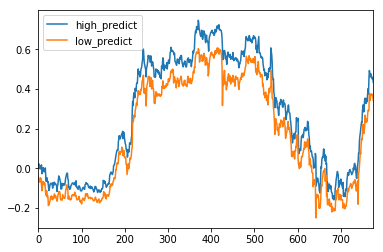

UP:
 WIN  :32
 LOST :24
 DRAW :36
DOWN:
 WIN  :69
 LOST :77
 DRAW :74
1674s


In [10]:
#high/lowの予想最大/最小値のグラフ（小さくてわからない）
result = pandas.DataFrame(high_predicted)
result.columns = ['high_predict']
result['low_predict'] = low_predicted
result.plot()
plt.show()

#
pre_check = []
temp_check = []
temp_close_open = []
temp_close_open_up_win = []
temp_close_open_up_lost = []
temp_close_open_down_win = []
temp_close_open_down_lost = []

#使わないデータも保持しているが
#予想したHighの最大値とLowの最小値を起点の日の翌日のOpenの
#と比較し、最初sに決定した差よりも大きい場合は上がり・下がりと
#判断する
#ただし、同時超えた場合はどちらが先に上がるか不明なためカウントしていない
#もしかすると
for i in range(len(low_predicted)):
    high_temp  = high_predicted[i] * diff_value + average_value
    low_temp   = low_predicted[i] * diff_value + average_value
    open_temp  = data.loc[i+test_start_count+1, 'open'] * diff_value + average_value
    close_temp = data.loc[i+test_start_count, 'close'] * diff_value + average_value

    if high_temp - close_temp >= check_treshhold and \
        close_temp - low_temp < check_treshhold:
        pre_check.append(1)
        temp_check.append(high_temp - open_temp)
        temp_close_open.append(abs(close_temp - open_temp))

    elif close_temp- low_temp >= check_treshhold and \
        high_temp - close_temp < check_treshhold:
        pre_check.append(-1)
        temp_check.append(low_temp - open_temp)
        temp_close_open.append(abs(close_temp - open_temp))
    #elif high_temp - open_temp >= check_treshhold and \
    #    open_temp- low_temp >= check_treshhold:
        
    #    if high_temp - open_temp > open_temp- low_temp:
    #        pre_check.append(1)
    #        temp_check.append(high_temp - open_temp)
    #    elif high_temp - open_temp < open_temp- low_temp:
    #        pre_check.append(-1)
    #        temp_check.append(low_temp - open_temp)
    #    else:
    #        pre_check.append(0)
    #        temp_check.append(0)

    #if high_temp - open_temp >= check_treshhold and \
    #    open_temp - low_temp < check_treshhold and \
    #    close_temp - open_temp <= up_c_o_diff and \
    #    close_temp - open_temp >= down_c_o_diff:
    #    pre_check.append(1)
    #    temp_check.append(high_temp - open_temp)

    #elif open_temp- low_temp >= check_treshhold and \
    #    high_temp - open_temp < check_treshhold and \
    #    close_temp - open_temp <= up_c_o_diff and \
    #    close_temp - open_temp >= down_c_o_diff:
    #    pre_check.append(-1)
    #    temp_check.append(low_temp - open_temp)

    else:
        pre_check.append(0)
        temp_check.append(0)

up_ok_count = 0
up_ng_count = 0
up_ev_count = 0
down_ok_count = 0
down_ng_count = 0
down_ev_count = 0
high_win = numpy.array([])
high_lost = numpy.array([])
low_win  = numpy.array([])
low_lost  = numpy.array([])

for i in range(len(pre_check)):
    if pre_check[i] == 1:
        if up_down[i] == pre_check[i]:
            up_ok_count += 1
            high_win = numpy.append(high_win, numpy.array(temp_check[i]))
        elif up_down[i] != pre_check[i] and up_down[i] == -1:
            up_ng_count += 1
            high_lost = numpy.append(high_lost, numpy.array(temp_check[i]))
        else:
            up_ev_count += 1
            
    elif pre_check[i] == -1:
        if up_down[i] == pre_check[i]:
            down_ok_count += 1
            low_win = numpy.append(low_win, numpy.array(temp_check[i]))
        elif up_down[i] != pre_check[i] and up_down[i] == 1:
            down_ng_count += 1
            low_lost = numpy.append(low_lost, numpy.array(temp_check[i]))
        else:
            down_ev_count += 1


print('==========')
print('UP:')
print(' WIN  :' + str(up_ok_count))
print(' LOST :' + str(up_ng_count))
print(' DRAW :' + str(up_ev_count))
print('DOWN:')
print(' WIN  :' + str(down_ok_count))
print(' LOST :' + str(down_ng_count))
print(' DRAW :' + str(down_ev_count))
#print('---------')
#print('UP ')
#print('  WIN  :' + str(high_win.mean()) + ' ' + str(high_win.std()))
#print('  LOST  :' + str(high_lost.mean()) + ' ' + str(high_lost.std()))
#print('DOWN ')
#print('  WIN  :' + str(low_win.mean()) + ' ' + str(low_win.std()))
#print('  LOST  :' + str(low_lost.mean()) + ' ' + str(low_lost.std()))


print(str(math.floor(time.time() - starttime)) + "s")